In [1]:
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf

In [2]:
tf.__version__

'2.4.0'

In [3]:
X = d2l.normal([1000, 2], 0.0, 1, tf.float32)
A = d2l.tensor([[1, 2], [-0.1, 0.5]], tf.float32)
b = d2l.tensor([1, 2], tf.float32)
data = d2l.matmul(X, A) + b

In [4]:
X

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.4394665 ,  0.24160361],
       [ 1.2087505 , -1.1883804 ],
       [ 0.68631256, -2.1683068 ],
       ...,
       [ 0.20275956,  1.0055181 ],
       [ 0.8474674 ,  0.5328942 ],
       [-0.12304003,  0.38081563]], dtype=float32)>

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


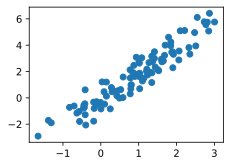

In [5]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(data[:100, 0]), d2l.numpy(data[:100, 1]));
print(f'The covariance matrix is\n{d2l.matmul(tf.transpose(A), A)}')

In [6]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [7]:
net_G = tf.keras.Sequential()
net_G.add(tf.keras.layers.Dense(2))

In [8]:
net_D = tf.keras.Sequential()
net_D.add(tf.keras.layers.Dense(5, activation='tanh'))
net_D.add(tf.keras.layers.Dense(3, activation='tanh'))
net_D.add(tf.keras.layers.Dense(1))

https://codingnote.cc/p/289284/

In [9]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    with tf.GradientTape() as D_tape:
        real_Y = net_D(X, training=True)
        fake_X = net_G(X, training=True)
        # Do not need to compute gradient for `net_G`, detach it from
        # computing gradients.
        fake_Y = net_D(tf.stop_gradient(fake_X), training=False)
        loss_D = (loss(tf.ones_like(X), real_Y) + loss(tf.zeros_like(X), fake_Y)) / 2
    grads = D_tape.gradient(loss_D, net_D.trainable_variables)
    trainer_D.apply_gradients(zip(grads, net_D.trainable_weights))
    return float(loss_D)

In [10]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    with tf.GradientTape() as G_tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z, training=True)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X, training=True)
        loss_G = loss(tf.ones_like(Z), fake_Y)
    grads = G_tape.gradient(loss_G, net_G.trainable_variables) 
    trainer_G.apply_gradients(zip(grads, net_G.trainable_weights))
    return float(loss_G)

from_logits=True
https://github.com/thisisiron/TF2-GAN/blob/master/gan/train.py

tf.nn.sigmoid_cross_entropy_with_logits https://www.tensorflow.org/tutorials/generative/cvae

In [11]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(reduction=
                tf.keras.losses.Reduction.SUM)
    tf.keras.initializers.RandomNormal(net_D, stddev=0.02)
    tf.keras.initializers.RandomNormal(net_G, stddev=0.02)
    trainer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    trainer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    net_D.compile(optimizer=trainer_D)
    net_G.compile(optimizer=trainer_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X in data_iter:
            batch_size = tf.shape(X)[0]
            Z = d2l.normal([batch_size, latent_dim], 0, 1, tf.float32)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = d2l.normal([100, latent_dim], 0, 1, tf.float32)
        fake_X = net_G(tf.stop_gradient(Z), training=False).numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

In [12]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, d2l.numpy(data[:100]))

array([[ 0.0537861 , -0.11591721],
       [-1.3097372 , -1.8988976 ],
       [ 1.4648738 ,  2.1573067 ],
       [ 1.9781153 ,  3.0414228 ],
       [-0.00476646,  0.6541244 ],
       [ 1.126363  ,  2.4825208 ],
       [ 0.7525764 ,  1.9596198 ],
       [ 1.9862254 ,  3.4737828 ]], dtype=float32)>,)
Consider rewriting this model with the Functional API.


TypeError: Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([8, 2])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'

In [12]:
X

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.47434857,  0.3043828 ],
       [ 0.00915392,  0.82858443],
       [ 0.15153293, -1.3138239 ],
       ...,
       [-1.6994526 , -0.47331712],
       [ 1.7982808 ,  1.9091058 ],
       [ 0.15317853,  1.1739804 ]], dtype=float32)>

In [13]:
Z

NameError: name 'Z' is not defined

In [14]:
data

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 1.4439104 ,  3.1008885 ],
       [ 0.92629546,  2.4326    ],
       [ 1.2829154 ,  1.6461539 ],
       ...,
       [-0.65212095, -1.6355639 ],
       [ 2.6073704 ,  6.5511146 ],
       [ 1.0357804 ,  2.8933473 ]], dtype=float32)>

In [15]:
tf.data.Dataset.from_tensors(X)

<TensorDataset shapes: (1000, 2), types: tf.float32>

In [12]:
tf.shape(X)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1000,    2])>

In [13]:
tf.convert_to_tensor(X)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 1.0931215 ,  2.8275273 ],
       [ 0.8639756 ,  0.09735021],
       [-0.14642486, -0.1999244 ],
       ...,
       [-0.08138083,  0.13587372],
       [ 0.01695178,  0.80529493],
       [ 0.30364874,  0.8255776 ]], dtype=float32)>

In [14]:
X == tf.convert_to_tensor(X)

<tf.Tensor: shape=(1000, 2), dtype=bool, numpy=
array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])>

In [12]:
net_D(tf.convert_to_tensor(X), training=True)

.90365326e-02],
       [-5.65821230e-02],
       [-3.58065963e-02],
       [-6.55139834e-02],
       [ 9.98779833e-02],
       [-6.08988702e-02],
       [ 5.72769642e-02],
       [ 1.94948912e-02],
       [ 3.22189406e-02],
       [-5.20620793e-02],
       [ 4.38127667e-03],
       [-3.94246578e-02],
       [ 1.03879571e-01],
       [-5.32668680e-02],
       [ 5.81621602e-02],
       [ 4.53850627e-02],
       [-4.50713970e-02],
       [-7.97018409e-04],
       [ 6.54728413e-02],
       [ 5.55095077e-02],
       [-1.72352530e-02],
       [ 4.54227626e-02],
       [ 1.44952059e-01],
       [-5.51512092e-02],
       [ 6.15314841e-02],
       [-4.19730842e-02],
       [-5.86254001e-02],
       [-4.07708138e-02],
       [ 1.91202611e-02],
       [ 8.98510367e-02],
       [ 5.20711914e-02],
       [ 5.91986552e-02],
       [-2.50110507e-01],
       [ 1.87605619e-05],
       [-5.45385778e-02],
       [-7.02647641e-02],
       [-5.69604039e-02],
       [ 1.07027888e-02],
       [-8.80497098e-0

In [13]:
net_D(X, training=True)

.90365326e-02],
       [-5.65821230e-02],
       [-3.58065963e-02],
       [-6.55139834e-02],
       [ 9.98779833e-02],
       [-6.08988702e-02],
       [ 5.72769642e-02],
       [ 1.94948912e-02],
       [ 3.22189406e-02],
       [-5.20620793e-02],
       [ 4.38127667e-03],
       [-3.94246578e-02],
       [ 1.03879571e-01],
       [-5.32668680e-02],
       [ 5.81621602e-02],
       [ 4.53850627e-02],
       [-4.50713970e-02],
       [-7.97018409e-04],
       [ 6.54728413e-02],
       [ 5.55095077e-02],
       [-1.72352530e-02],
       [ 4.54227626e-02],
       [ 1.44952059e-01],
       [-5.51512092e-02],
       [ 6.15314841e-02],
       [-4.19730842e-02],
       [-5.86254001e-02],
       [-4.07708138e-02],
       [ 1.91202611e-02],
       [ 8.98510367e-02],
       [ 5.20711914e-02],
       [ 5.91986552e-02],
       [-2.50110507e-01],
       [ 1.87605619e-05],
       [-5.45385778e-02],
       [-7.02647641e-02],
       [-5.69604039e-02],
       [ 1.07027888e-02],
       [-8.80497098e-0

In [14]:
net_D(tf.convert_to_tensor(X), training=True) == net_D(X, training=True)

<tf.Tensor: shape=(1000, 1), dtype=bool, numpy=
array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [